In [1]:
from random import sample
import cmath
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 

%matplotlib widget

# Formatting for plots
label_font = {'fontname':'sans-serif', 'size':'20', 'color':'black', 'weight':'normal',
          'verticalalignment':'bottom'} 
title_font = {'fontname':'sans-serif', 'size':'16', 'color':'black', 'weight':'bold'}
legend_font = {'family':'sans-serif', 'size':'10', 'style':'normal'} 

# Check if a string is a number
def isNum(x):
    try:
        float(x)
        return True
    except:
        return False

# Get a list of files given a directory name    
def getFiles(dirName):
    allFiles = []
    os.chdir(dirName)
    for aFile in glob.glob("*.csv"):
        allFiles.append(aFile)
    return allFiles

# Get data return a list of dataframes
def getData(dataDir, fileNames):
    allData = []
    for aFile in fileNames:
        with open(dataDir + aFile) as f:
            holder = (pd.read_csv(f))
            if 'S11_Phase' in holder.keys():
                allData.append(holder)
    return allData

# Compute all the S factor stuff in the q formula equation
def computeSFactor(sData):
    avgS11 = np.mean(sData, axis = 0)
    num = []
    den = []
    for val in range(len(sData[0])):
        num.append(np.mean([np.abs(x - avgS11[val])**2 for x in (np.transpose(sData))[val]]))
        den.append((1. - np.abs(avgS11[val])**2)**2)

    return np.abs(avgS11) #np.asarray(num) / np.asarray(den)

# Old function that is a hamfisted way of getting data from the WebPlotDigitizer csv files
def getDataMan(dataDir, dataFile):
    freqs = []
    amps = []
    with open(dataDir + '/' + dataFile, 'r') as f:
        f.readline()
        for line in f:
            holder = line.split('\t')
            if len(holder) == 2 and isNum(holder[0]) and isNum(holder[1]):
                vals = [float(x) for x in holder]
                freqs.append(vals[0])
                amps.append(vals[1])
    return np.asarray(freqs), np.asarray(amps)

# Return S11 as an Ae^i(phi) value - more human readable ways of doing this but lists are fun
def getComplexS11(allData, dB = False):
    if dB:
        return [np.asarray([10**(val[0]/20.) * cmath.exp(complex(0, val[1])) for val in zip(np.asarray(x['S11_Magnitude']), np.asarray(x['S11_Phase']))]) for x in allData]
    return [np.asarray([val[0] * cmath.exp(complex(0, val[1])) for val in zip(np.asarray(x['S11_Magnitude (linear)']), np.asarray(x['S11_Phase']))]) for x in allData]
   
# Return a 'median fit' - note that this function changes the length of the input array
def calcMedian(arr, medLen):
    extraBit = len(arr) % medLen
    # Needed because this array just throws off the extra at the end using the negative index notation.
    # But if there is no extra then you want to go to the end of the array
    if extraBit != 0:
        medArr = np.median(np.reshape(arr[:-extraBit], (-1, medLen)), axis = 1)     
    else:
        medArr = np.median(np.reshape(arr[:], (-1, medLen)), axis = 1)
    return medArr

In [9]:
# Data directories for data - NEED TO CHANGE THIS
dataDirNew = 'QTesting/Bicon-314-30positions-30Oct2023/'
#dataDirOld = './QTesting/Bicon-314-10positions-25Apr2023/'

# Get list of files
allFilesNew = getFiles(dataDirNew)
#allFilesOld = getFiles(dataDirOld)

# Stupid way of sorting file names (needed to remove weird data)
allFilesNew.sort(key = lambda x:int(x[x.index('p') + 1:x.index('.csv')]))
#allFilesOld.sort(key = lambda x:int(x[x.index('Pos') + 3:x.rindex('_')]))

# Keep in if you want to remove data that I have self-identified as very extreme edge cases
removeBad = False

if removeBad:
    badFiles = [3, 7, 12, 14, 15, 18,19, 24]
    allFilesNew = [val[0] for val in zip(allFilesNew, np.asarray(range(1,len(allFilesNew)+1))) if val[1] not in badFiles]
    print(allFilesNew)


# Get a list of data frames for all the data
allDataNew = getData(dataDirNew, allFilesNew)
#allDataOld = getData(dataDirOld, allFilesOld)

# Get frequency arrays 
allFreqsNew = np.asarray([np.asarray(x['Frequency']) for x in allDataNew])
#allFreqsOld = np.asarray([np.asarray(x['Frequency']) for x in allDataOld])

# Get S11 values 
allS11New = getComplexS11(allDataNew)
#allS11Old = getComplexS11(allDataOld, dB = True)

meanS11New = (np.mean(np.abs(allS11New), axis = 0))
#meanS11Old = (np.mean(np.abs(allS11Old), axis = 0))

#holder = np.asarray([complex(val[0], val[1]) for val in zip(np.asarray(allData['S11_Real'])[0], np.asarray(allData['S11_Imaginary'])[0])])
#allS11 = np.asarray([np.asarray([complex(val[0], val[1]) for val in zip(np.asarray(allData[x]['S11_Real']), np.asarray(allData[x]['S11_Imaginary']))]) for x in range(len(allFreqs))])
sPartNew = computeSFactor(allS11New)
#sPartOld = computeSFactor(allS11Old)

# Calculate median data
medLen = 10
sPartNewMed = calcMedian(np.abs(meanS11New), medLen)
#sPartOldMed = calcMedian(np.abs(meanS11Old), medLen)
allFreqsNewMed = calcMedian(allFreqsNew[0], medLen)
#allFreqsOldMed = calcMedian(allFreqsOld[0], medLen)

#Plot data
plt.close('all')
plt.figure()
#plt.plot((allFreqsRS[0])/1e6, (sPart))
#plt.plot(allFreqs[0]/1e6, np.abs(allS11[2]), label = 'Position ')
plt.plot(allFreqsNewMed/1e6, sPartNewMed, label = 'Mean 4/25 Data (10 Pos) Median Length = ' + str(medLen))
#plt.plot(allFreqsOldMed/1e6, sPartOldMed, label = 'Mean 10/30 Data (30 Pos) Median Length = ' + str(medLen))

plt.xlabel('Frequency (MHz)', labelpad = 25, **label_font)
plt.ylabel(r'|S$_{11}$ (lin)|', **label_font)
plt.xlim([0, 450])
plt.legend(prop = legend_font)


FileNotFoundError: [Errno 2] No such file or directory: 'QTesting/Bicon-314-30positions-30Oct2023/'

[ 30000000  30088888  30177777 ... 429822222 429911111 430000000]


(0.0, 450.0)

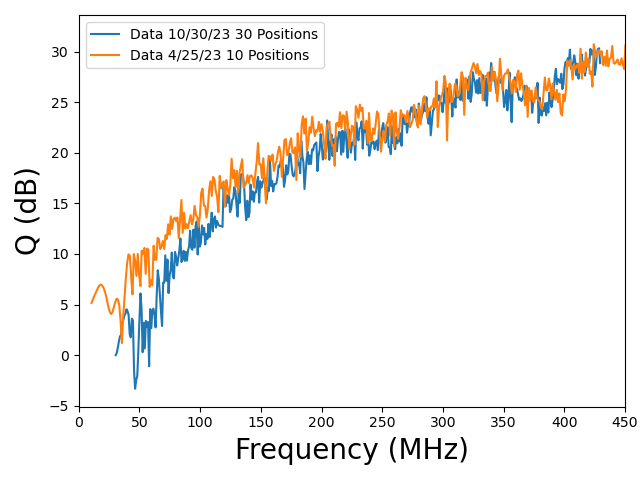

In [3]:
# The rest of this is calculating Q and comparing it to theory
# Theory approximations are all wrong and need to be redone
dimX = 2.438
dimY = 3.048
dimZ = 3.658
volume = dimX * dimY * dimZ
wavelength = 3e8 / allFreqsNew[0]
radEffic = 0.8

# Calculate Q
qValNew = 8*(np.pi)**2*volume/wavelength**3*sPartNew/radEffic**2
qValOld = 8*(np.pi)**2*volume/wavelength**3*sPartOld/radEffic**2

medLen = 10
#extraBit = len(qValNew) % medLen

print(allFreqsNew[0])
qAnt = 2 * (2*np.pi*allFreqsNew[0]/(3e8))**3*volume / np.pi
muSteel = 1000 
deltaS = np.sqrt(2 / (2*np.pi*allFreqsNew[0]*muSteel*4*np.pi*1e-7*1.7e7))
surfaceArea = 2*(dimX*dimY + dimX*dimZ + dimY*dimZ)
qRoom = 1.5*volume / (muSteel * surfaceArea * deltaS)
qTheory = 1 / (1/qAnt + 1/qRoom)

medQNew = calcMedian(qValNew, medLen)
medFreqsNew = calcMedian(allFreqsNew[0], medLen)
medQOld = calcMedian(qValOld, medLen)
medFreqsOld =calcMedian(allFreqsOld[0], medLen)

plt.close('all')
plt.figure()
#plt.plot(allFreqsNew[0]/1e6, (qTheory), label = 'Theory')
#plt.plot((allFreqsMS[0])/1e6, qValMS)
plt.plot((medFreqsNew)/1e6, 10*np.log10(medQNew), label = 'Data 10/30/23 30 Positions')
plt.plot((medFreqsOld)/1e6, 10*np.log10(medQOld), label = 'Data 4/25/23 10 Positions')

plt.xlabel('Frequency (MHz)', labelpad = 25, **label_font)
plt.ylabel('Q (dB)', **label_font)
plt.legend(prop = legend_font)
plt.tight_layout()
plt.xlim([0, 450])
#plt.savefig('/home/bgodfrey/Downloads/QMeasurement_BiconComparison_RemoveOutliers_10-30-23.png')